In [1]:
import numpy as np
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
from estimate import test_mse_pop

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams.update({"font.size": 15})

In [2]:
# DAG
p = 6
B = np.loadtxt("B_5.csv")
b_causal = B[-1, :-1]
C = inv(np.eye(p) - B)

# Observational stats
Sigma_eps = np.random.rand(p, p)
Sigma_eps = Sigma_eps @ Sigma_eps.T
Sigma_eps = Sigma_eps / norm(Sigma_eps, 2)
G0 = np.eye(p) + Sigma_eps
Gram_0 = C @ G0 @ C.T
Sigma_0 = Gram_0

# Interventional stats
mu1_noise = np.diag(np.random.rand(p, p)).flatten()
mu1_noise[-1] = 0
L1_noise = np.random.rand(p, p)
L1_noise = L1_noise @ L1_noise.T
L1_noise[-1, :] = 0
L1_noise[:, -1] = 0
L1_noise = L1_noise / norm(L1_noise, 2)
G1_G0 = L1_noise
mu1 = C @ mu1_noise
G1 = G0 + G1_G0
Sigma_1 = C @ G1 @ C.T
Gram_1 = Sigma_1 + np.outer(mu1, mu1)

# Test distribution
W = np.diag([1, 2, 3, 4, 5, 6])
gram_v_base = W @ (C @ G1_G0 @ C.T + np.outer(mu1, mu1)) @ W / 2

In [3]:
# Estimations
gamma = 10
M = (Gram_1[:-1, :-1] - Gram_0[:-1, :-1]) * gamma / 2 + Gram_0[:-1, :-1]
N = gamma / 2 * (Gram_1[:-1, -1] - Gram_0[:-1, -1]) + Gram_0[:-1, -1]
b_ours = inv(M) @ N
b_anchor = inv(Gram_0[:-1, :-1] + Gram_1[:-1, :-1] + (gamma - 1) * np.outer(mu1[:-1], mu1[:-1])) @ (Gram_0[:-1, -1] + Gram_1[:-1, -1] + (gamma - 1) * mu1[:-1] * mu1[-1])
b_pooled = inv(Sigma_0[:-1, :-1] + Sigma_1[:-1, :-1] + np.outer(mu1[:-1], mu1[:-1])) @ (Sigma_0[:-1, -1] + Sigma_1[:-1, -1] + mu1[:-1] * mu1[-1])
b_obs = inv(Sigma_0[:-1, :-1]) @ Sigma_0[:-1, -1]
b_causal = B[-1, :-1]
M = W[:-1, :-1] @ (Gram_1[:-1, :-1] - Gram_0[:-1, :-1]) @ W[:-1, :-1] * gamma / 2 + Gram_0[:-1, :-1]
N = gamma / 2 * W[-1, -1] * W[:-1, :-1] @ (Gram_1[:-1, -1] - Gram_0[:-1, -1]) + Gram_0[:-1, -1]
b_adap = inv(M) @ N

In [4]:
# Test

# Loop through perturbation strengths
perturb_stren = np.linspace(0, 15, 15)

mse_ours = []
mse_anchor = []
mse_pooled = []
mse_obs = []
mse_causal = []
mse_adap = []

for l in perturb_stren:
    Gram_t = Gram_0 + l * gram_v_base
    mse_ours.append(test_mse_pop(Gram_t, b_ours))
    mse_anchor.append(test_mse_pop(Gram_t, b_anchor))
    mse_obs.append(test_mse_pop(Gram_t, b_obs))
    mse_pooled.append(test_mse_pop(Gram_t, b_pooled))
    mse_causal.append(test_mse_pop(Gram_t, b_causal))
    mse_adap.append(test_mse_pop(Gram_t, b_adap))

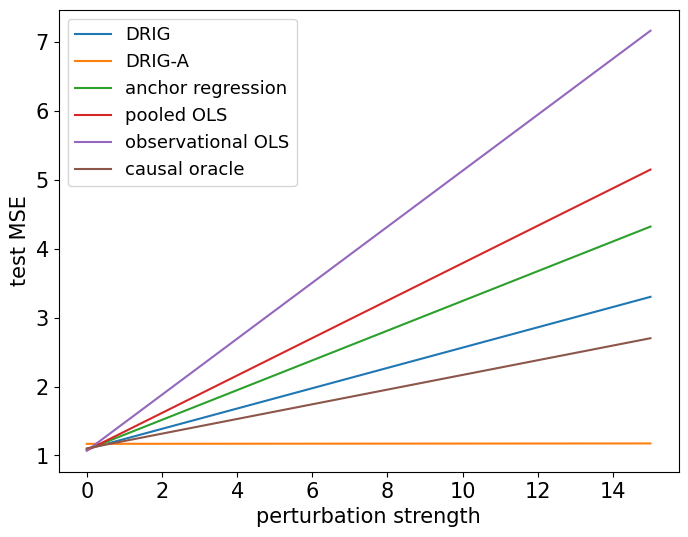

In [5]:
# Plotting
plt.figure()
plt.plot(perturb_stren, mse_ours, label="DRIG")
plt.plot(perturb_stren, mse_adap, label="DRIG-A")
plt.plot(perturb_stren, mse_anchor, label="anchor regression")
plt.plot(perturb_stren, mse_pooled, label="pooled OLS")
plt.plot(perturb_stren, mse_obs, label="observational OLS")
plt.plot(perturb_stren, mse_causal, label="causal oracle")

plt.xlabel("perturbation strength")
plt.ylabel("test MSE")
# plt.ylim(bottom=1, top=6)
plt.legend(loc="best", fontsize=13)
# plt.savefig("./results/illus-adap-cheat.pdf", bbox_inches="tight")
plt.show()